In [ ]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install nibabel matplotlib tqdm --quiet

# Import required libraries
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [ ]:
import torch.nn.functional as F

# Path to dataset (update this path based on your Google Drive structure)
dataset_dir = "/content/drive/MyDrive/data/Task06_Lung/Task06_Lung/imagesTr"

class Medical3DEnhancementDataset(Dataset):
    def __init__(self, images_dir, noise_level=0.1, target_size=(64, 64, 64)):
        """
        Dataset for 3D medical image enhancement.
        Args:
            images_dir: Path to directory containing .nii.gz files.
            noise_level: Standard deviation of Gaussian noise to simulate noisy images.
            target_size: Tuple specifying the size to resize the 3D volumes.
        """
        self.image_files = sorted(glob.glob(os.path.join(images_dir, "*.nii.gz")))
        self.noise_level = noise_level
        self.target_size = target_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the clean 3D image
        image_path = self.image_files[idx]
        image = nib.load(image_path).get_fdata()

        # Normalize to [0, 1]
        image = (image - image.min()) / (image.max() - image.min())

        # Add Gaussian noise
        noisy_image = image + np.random.normal(0, self.noise_level, image.shape)
        noisy_image = np.clip(noisy_image, 0, 1)

        # Convert to tensors (C, D, H, W) and resize
        image = torch.from_numpy(np.expand_dims(image, axis=0)).float()
        noisy_image = torch.from_numpy(np.expand_dims(noisy_image, axis=0)).float()
        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False).squeeze(0)
        noisy_image = F.interpolate(noisy_image.unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False).squeeze(0)

        return noisy_image, image

# Initialize the dataset and DataLoader
noise_level = 0.05
train_dataset = Medical3DEnhancementDataset(dataset_dir, noise_level=noise_level)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Inspect the dataset
print(f"Number of samples in dataset: {len(train_dataset)}")
noisy_image, clean_image = train_dataset[0]
print(f"Noisy image shape: {noisy_image.shape}, Clean image shape: {clean_image.shape}")


Number of samples in dataset: 63
Noisy image shape: torch.Size([1, 64, 64, 64]), Clean image shape: torch.Size([1, 64, 64, 64])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -(torch.log(torch.tensor(10000.0)) / (half_dim - 1)))
        emb = t.unsqueeze(1) * emb.unsqueeze(0)
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class UNet3D_Diffusion(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        # Project time embeddings to appropriate channel sizes
        self.time_proj1 = nn.Linear(time_emb_dim, 64)
        self.time_proj2 = nn.Linear(time_emb_dim, 128)
        self.time_proj3 = nn.Linear(time_emb_dim, 256)

        # Encoder (down) layers
        self.down1 = self.conv_block(1, 64, downsample=True)
        self.down2 = self.conv_block(64, 128, downsample=True)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder (up) layers
        self.up1 = self.conv_block(256, 128, upsample=True)
        self.up2 = self.conv_block(128, 64, upsample=True)

        self.final_conv = nn.Conv3d(64, 1, kernel_size=1)

    def conv_block(self, in_c, out_c, downsample=False, upsample=False):
        layers = []
        if downsample:
            layers.append(nn.Conv3d(in_c, out_c, kernel_size=4, stride=2, padding=1))
        elif upsample:
            layers.append(nn.ConvTranspose3d(in_c, out_c, kernel_size=4, stride=2, padding=1))
        else:
            layers.append(nn.Conv3d(in_c, out_c, kernel_size=3, padding=1))
        layers.extend([nn.GroupNorm(8, out_c), nn.SiLU()])
        return nn.Sequential(*layers)

    def forward(self, x, t):
        # Compute time embeddings
        t_emb = self.time_mlp(t)
        t_emb1 = self.time_proj1(t_emb).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # 64 channels
        t_emb2 = self.time_proj2(t_emb).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # 128 channels
        t_emb3 = self.time_proj3(t_emb).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # 256 channels

        # Downsample path
        x1 = self.down1(x)          # 1 -> 64 channels
        # Add time embedding after down1
        x1 = x1 + t_emb1

        x2 = self.down2(x1)         # 64 -> 128 channels
        # Add time embedding after down2
        x2 = x2 + t_emb2

        # Bottleneck
        bottleneck = self.bottleneck(x2)   # 128 -> 256 channels
        # Add time embedding at bottleneck
        bottleneck = bottleneck + t_emb3

        # Upsample path
        # up1: 256 -> 128 channels
        x = self.up1(bottleneck)
        # Align x2 with x shape
        x2_resized = F.interpolate(x2, size=x.shape[2:], mode='trilinear', align_corners=False)
        # Add skip connection and time embedding at this level
        x = x + x2_resized + t_emb2

        # up2: 128 -> 64 channels
        x = self.up2(x)
        # Align x1 with x shape
        x1_resized = F.interpolate(x1, size=x.shape[2:], mode='trilinear', align_corners=False)
        # Add skip connection and time embedding at this level
        x = x + x1_resized + t_emb1

        # Final convolution
        x = self.final_conv(x)
        return x


In [ ]:
# Initialize model, optimizer, and loss function
model = UNet3D_Diffusion().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training Loop
epochs = 5
num_diffusion_steps = 1000
betas = torch.linspace(1e-4, 0.02, num_diffusion_steps).to(device)
alphas_cumprod = torch.cumprod(1 - betas, dim=0).to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for noisy_image, clean_image in tqdm(train_loader):
        noisy_image, clean_image = noisy_image.to(device), clean_image.to(device)

        # Random timestep t
        t = torch.randint(0, num_diffusion_steps, (noisy_image.size(0),), device=device).long()

        # Compute noise
        alpha_cumprod_t = alphas_cumprod[t].reshape(-1, 1, 1, 1, 1)
        noise = torch.randn_like(noisy_image)
        noisy_t = alpha_cumprod_t.sqrt() * clean_image + (1 - alpha_cumprod_t).sqrt() * noise

        # Model prediction and loss
        pred_noise = model(noisy_t, t)
        loss = criterion(pred_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


100%|██████████| 63/63 [06:07<00:00,  5.83s/it]


Epoch 1/5, Loss: 1.0316


100%|██████████| 63/63 [06:08<00:00,  5.85s/it]


Epoch 2/5, Loss: 0.8676


100%|██████████| 63/63 [06:07<00:00,  5.84s/it]


Epoch 3/5, Loss: 0.6794


100%|██████████| 63/63 [06:07<00:00,  5.83s/it]


Epoch 4/5, Loss: 0.5965


100%|██████████| 63/63 [06:08<00:00,  5.84s/it]

Epoch 5/5, Loss: 0.4848


Noisy shape: (64, 64, 64)
Clean shape: (64, 64, 64)
Enhanced shape: (64, 64, 64)


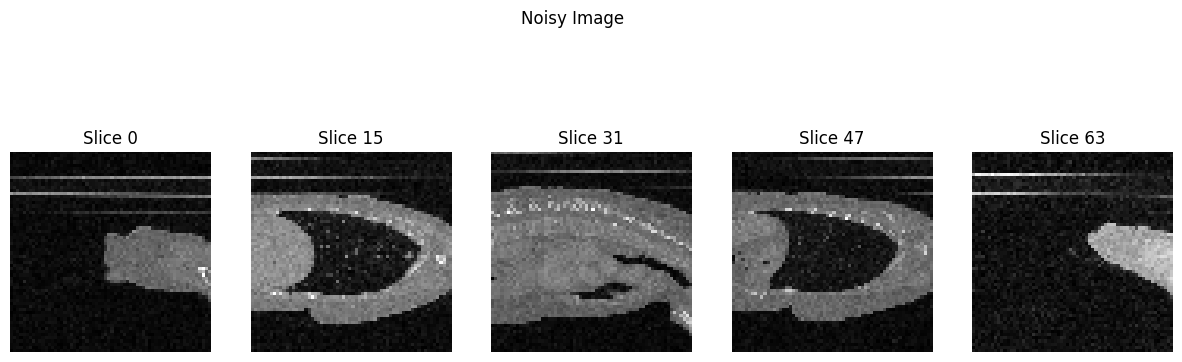

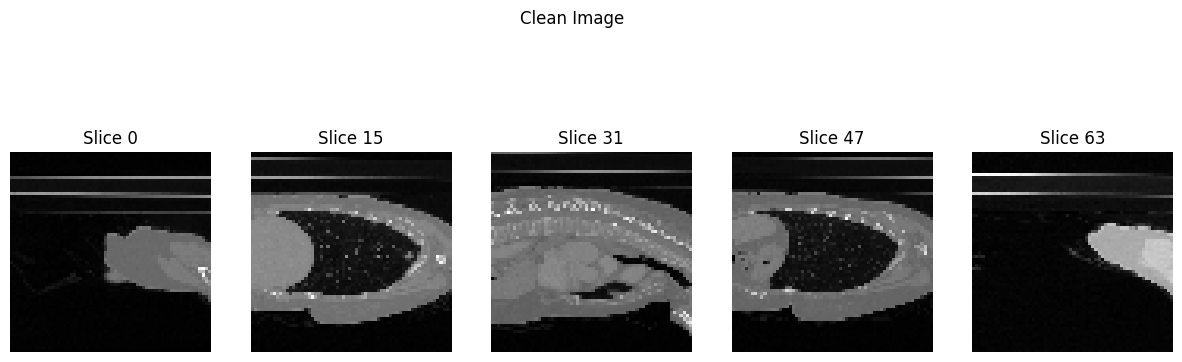

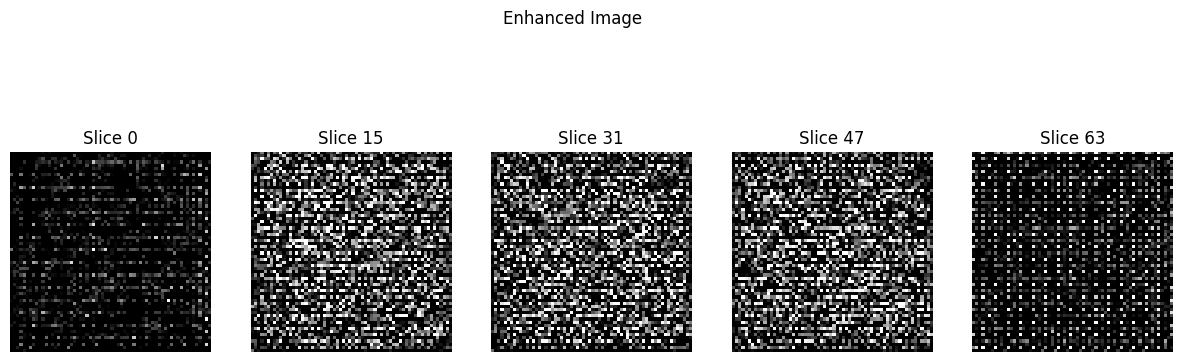

In [ ]:
@torch.no_grad()
def enhance_image(model, noisy_image, steps=50):
    model.eval()
    img = noisy_image.clone()
    for i in reversed(range(steps)):
        t_tensor = torch.tensor([i], device=device).long()
        pred_noise = model(img, t_tensor)
        img = img - pred_noise
        img = torch.clamp(img, 0, 1)
    return img

# Test on one sample
noisy_image, clean_image = train_dataset[0]
noisy_image = noisy_image.unsqueeze(0).to(device)  # Add batch dimension
enhanced_image = enhance_image(model, noisy_image)

# Convert to numpy for visualization
noisy_np = noisy_image.squeeze().cpu().numpy()
clean_np = clean_image.squeeze().cpu().numpy()
enhanced_np = enhanced_image.squeeze().cpu().numpy()

# Print shapes
print("Noisy shape:", noisy_np.shape)
print("Clean shape:", clean_np.shape)
print("Enhanced shape:", enhanced_np.shape)

# Call the visualization functions
show_slices(noisy_np, title="Noisy Image")
show_slices(clean_np, title="Clean Image")
show_slices(enhanced_np, title="Enhanced Image")


# Visualize slices
def show_slices(volume, title="", num_slices=5):
    depth = volume.shape[2]

    depth = volume.shape[0]
    indices = np.linspace(0, depth - 1, num_slices).astype(int)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):

        plt.subplot(1, num_slices, i + 1)
        plt.imshow(volume[idx], cmap="gray")
        plt.title(f"Slice {idx}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()



In [ ]:
import torch
import math
import numpy as np

def compute_psnr(clean, enhanced, max_val=1.0):

    mse = torch.mean((clean - enhanced) ** 2)
    psnr = 10 * math.log10((max_val**2) / mse.item())
    return psnr


D,H,W = 16,16,16
clean_np = np.random.rand(D,H,W)
enhanced_np = clean_np + np.random.normal(0, 0.01, (D,H,W))


clean_np = np.clip(clean_np, 0, 1)
enhanced_np = np.clip(enhanced_np, 0, 1)


clean = torch.from_numpy(clean_np).float()
enhanced = torch.from_numpy(enhanced_np).float()


psnr_value = compute_psnr(clean, enhanced)
print("PSNR:", psnr_value)


PSNR: 40.15837195340937
